# <font style="font-size: 26px;" color='red'>Brain MRI Detector & Segmentation using DeepLabv3+</font>

## <font style="font-size: 18px;" color='green'>Introduction</font>
<span style="font-size: 13px;">
**DeepLabv3+** is an advanced architecture for semantic segmentation developed by Google Research. It improves image segmentation by introducing a context extraction module based on **DeepLabv3** and a **lightweight decoder module** for better edge reconstruction. Its design leverages **dilated convolutions** and efficient spatial scaling techniques.
</span>

## <font style="font-size: 18px;" color='green'>DeepLabv3+ Architecture for Image Segmentation</font>
<span style="font-size: 13px;">
**DeepLabv3+** combines advanced techniques like **dilated convolutions**, **ASPP (Atrous Spatial Pyramid Pooling)**, and a **decoder module**, making the architecture suitable for capturing both global context and fine local details.
</span>

### <font style="font-size: 16px;" color='purple'>1. Key Components of DeepLabv3+</font>
<span style="font-size: 13px;">

- <b style="color: blue;">Encoder (Feature Extraction):</b>
  - Built on a backbone (e.g., ResNet or Xception) for extracting rich features from the input image.
  - Uses **dilated convolutions (atrous convolutions)** to capture context at various scales without losing spatial resolution.

- <b style="color: blue;">Atrous Spatial Pyramid Pooling (ASPP):</b>
  - Aggregates contextual information at multiple scales.
  - Combines dilated convolutions with different dilation rates.
  - Includes a **global average pooling** to capture global context.

- <b style="color: blue;">Decoder (Upsampling Path):</b>
  - Reconstructs the segmentation mask with fine details using a lightweight decoding path.
  - Fuses fine-grained features from the encoder with ASPP outputs.
</span>
<img src="../Images/Deeplabv3.png" alt="Segmentation de Tumeur" style="width: 80%; border: 1px solid black;">

### <font style="font-size: 16px;" color='purple'>2. Detailed Components</font>

#### <b style="color: blue; font-size: 14px;">Encoder:</b>
<span style="font-size: 13px;">
- <b>Backbone:</b>
  - Uses a pre-trained network (ResNet, Xception) as the base for extracting high-level features.
- <b>Dilated Convolutions:</b>
  - Expands the receptive field without reducing the spatial resolution.
  - Captures multi-scale features, suitable for objects of varying sizes.
</span>

#### <b style="color: blue; font-size: 14px;">Atrous Spatial Pyramid Pooling (ASPP):</b>
<span style="font-size: 13px;
">
ASPP is a key module for capturing context at different scales.

- <b>Structure:</b>
  - Multiple branches with dilated convolutions at varying dilation rates.
  - One branch performs **global average pooling**, followed by a dense layer.
- <b>Fusion:</b>
  - Outputs from all branches are concatenated and passed through a 1×1 convolution layer to merge the information.
</span>

#### <b style="color: blue; font-size: 14px;">Decoder:</b>
<span style="font-size: 13px;">
The decoder module reconstructs the segmentation map while preserving fine details.

- <b>Steps:</b>
  1. Fine-grained features from the encoder are fused with the ASPP output.
  2. A 3×3 convolution refines the fused features.
  3. **Bilinear upsampling** doubles the spatial dimensions until the original size is restored.
  
- <b>Final Output:</b>
  - A **1×1 convolution layer** with **softmax activation** produces the pixel-wise segmentation map.
</span>

### <font style="font-size: 16px;" color='purple'>3. Strengths of DeepLabv3+</font>
<span style="font-size: 13px; ">
- Captures global context using ASPP.
- Handles variations in object sizes with dilated convolutions.
- Improves edge precision with the decoder module.
- Computationally efficient, making it suitable for real-time applications.
</span>


In [1]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation


Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
License(s): CC-BY-NC-SA-4.0
 97%|███████████████████████████████████████▉ | 696M/714M [00:02<00:00, 287MB/s]
100%|█████████████████████████████████████████| 714M/714M [00:02<00:00, 263MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile('lgg-mri-segmentation.zip', 'r') as zip_ref:
    files_to_extract = [f for f in zip_ref.namelist() if f.startswith("kaggle_3m/")]
    zip_ref.extractall('/kaggle/working/lgg_mri_segmentation', members=files_to_extract)


In [ ]:
import os
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:

from PIL import Image

def check_tumor_in_mask(mask_path):
    try:
        img = Image.open(mask_path)
        img = np.array(img)

        if np.max(img) > 0:
            return 1 
        else:
            return 0 
    except Exception as e:
        print(f"Erreur de lecture du masque {mask_path}: {e}")
        return -1 

DataPath = "/kaggle/working/lgg_mri_segmentation/kaggle_3m/"

dirs = []
images = []
masks = []
diagnoses = []

for dirname, _, filenames in os.walk(DataPath):
    for filename in filenames:
        if 'mask' in filename:  
           
            mask_path = os.path.join(dirname, filename)
            dirs.append(dirname.replace(DataPath, ''))
            masks.append(filename)
            
            images.append(filename.replace('_mask', '')) 
            diagnosis = check_tumor_in_mask(mask_path)
            diagnoses.append(diagnosis)

patient_mri_df = pd.DataFrame({'patient_id': dirs, 'images': images, 'masks': masks, 'diagnosis': diagnoses})

patient_mri_df.head()


patient_id                        images  \
0  TCGA_CS_6186_20000601   TCGA_CS_6186_20000601_1.tif   
1  TCGA_CS_6186_20000601  TCGA_CS_6186_20000601_13.tif   
2  TCGA_CS_6186_20000601  TCGA_CS_6186_20000601_18.tif   
3  TCGA_CS_6186_20000601   TCGA_CS_6186_20000601_7.tif   
4  TCGA_CS_6186_20000601  TCGA_CS_6186_20000601_15.tif   

                               masks  diagnosis  
0   TCGA_CS_6186_20000601_1_mask.tif          0  
1  TCGA_CS_6186_20000601_13_mask.tif          0  
2  TCGA_CS_6186_20000601_18_mask.tif          1  
3   TCGA_CS_6186_20000601_7_mask.tif          0  
4  TCGA_CS_6186_20000601_15_mask.tif          1

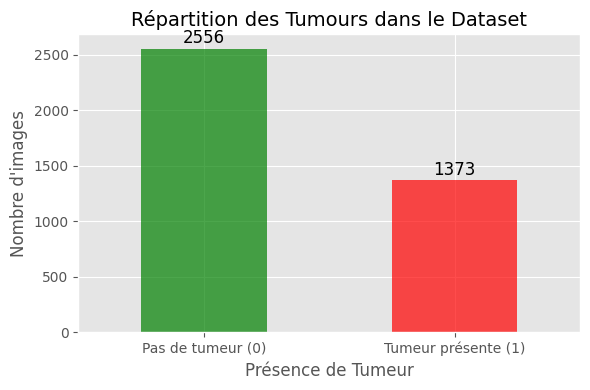

In [5]:
import matplotlib.pyplot as plt
diagnosis_counts = patient_mri_df['diagnosis'].value_counts()

plt.figure(figsize=(6, 4))
diagnosis_counts.plot(kind='bar', color=['green', 'red'], alpha=0.7)
plt.title('Répartition des Tumours dans le Dataset', fontsize=14)
plt.xlabel('Présence de Tumeur', fontsize=12)
plt.ylabel('Nombre d\'images', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Pas de tumeur (0)', 'Tumeur présente (1)'], rotation=0)
for i, count in enumerate(diagnosis_counts):
    plt.text(i, count + 10, str(count), ha='center', va='bottom', fontsize=12)
plt.tight_layout()
plt.show()


In [6]:
pip install imageio


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


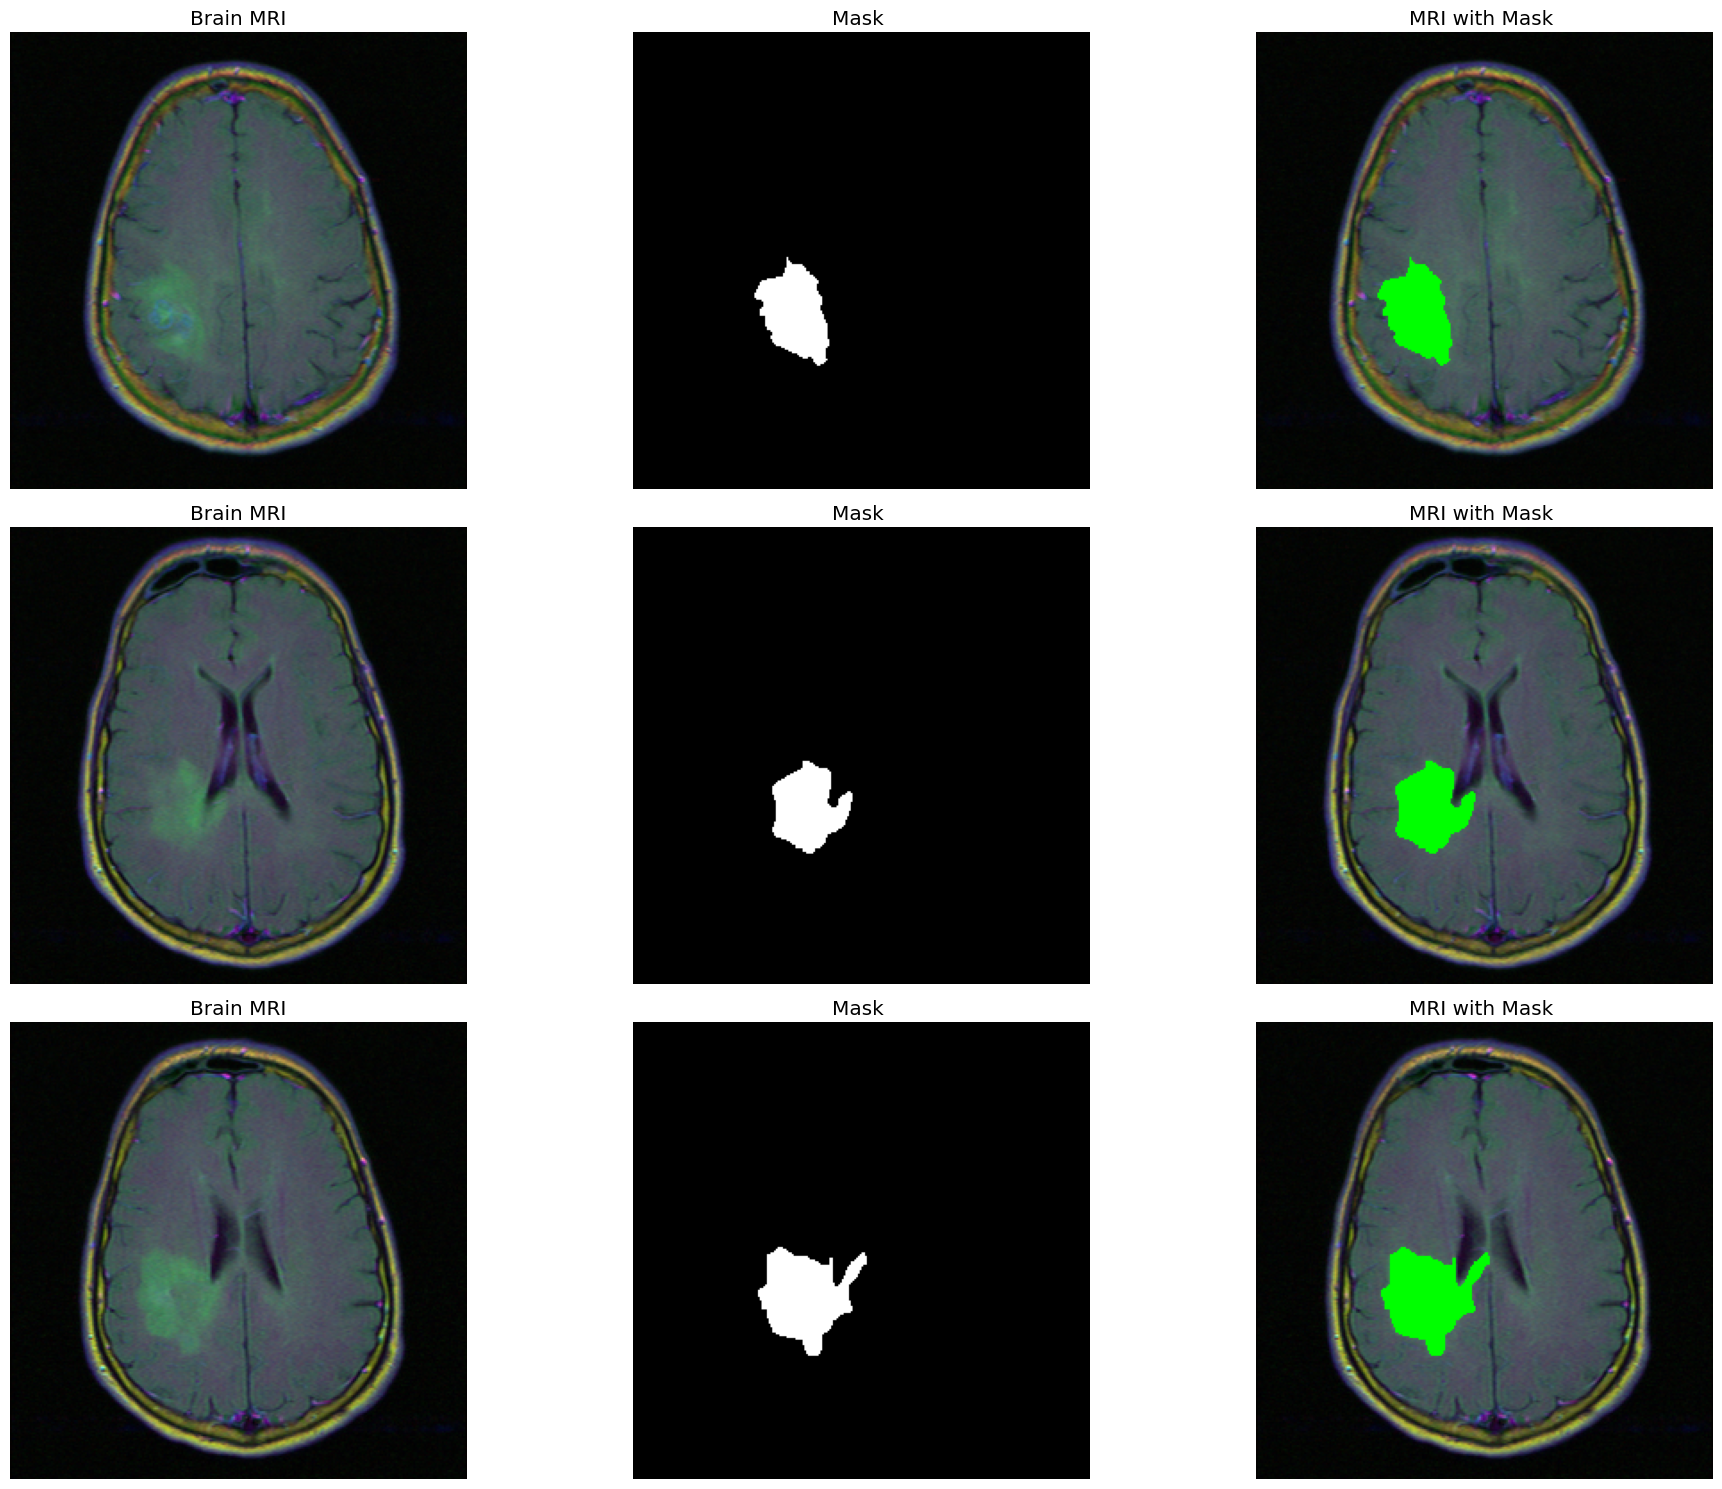

In [ ]:
import os
from skimage.io import imread
import matplotlib.pyplot as plt

count = 0
fig, axs = plt.subplots(3, 3, figsize=(20, 15))
axs = axs.flatten()

for i, row in patient_mri_df.iterrows():
    if row['diagnosis'] == 1:
        img_path = os.path.join(DataPath, row['patient_id'], row['images'])
        mask_path = os.path.join(DataPath, row['patient_id'], row['masks'])

        img = imread(img_path)  
        mask = imread(mask_path)  

        axs[count].imshow(img)
        axs[count].set_title("Brain MRI")
        axs[count].axis('off')

        axs[count + 1].imshow(mask, cmap='gray')
        axs[count + 1].set_title(f"Mask ")
        axs[count + 1].axis('off')

        img_with_mask = img.copy()
        img_with_mask[mask == 255] = (0, 255, 0)
        axs[count + 2].imshow(img_with_mask)
        axs[count + 2].set_title(f"MRI with Mask ")
        axs[count + 2].axis('off')

        count += 3

    if count >= 9:
        break

fig.tight_layout()
plt.show()


In [ ]:

train, test = train_test_split(patient_mri_df, test_size=0.25, random_state=25)

train, val = train_test_split(train, test_size=0.1, random_state=25)

print(f"Taille de l'ensemble d'entraînement: {len(train)}")
print(f"Taille de l'ensemble de validation: {len(val)}")
print(f"Taille de l'ensemble de test: {len(test)}")

print(test.head())


Taille de l'ensemble d'entraînement: 2651
Taille de l'ensemble de validation: 295
Taille de l'ensemble de test: 983
                 patient_id                        images  \
1006  TCGA_DU_5852_19950709  TCGA_DU_5852_19950709_28.tif   
1217  TCGA_CS_4942_19970222   TCGA_CS_4942_19970222_9.tif   
3267  TCGA_CS_6290_20000917  TCGA_CS_6290_20000917_20.tif   
2033  TCGA_DU_A5TS_19970726   TCGA_DU_A5TS_19970726_4.tif   
3419  TCGA_DU_7013_19860523  TCGA_DU_7013_19860523_43.tif   

                                  masks  diagnosis  
1006  TCGA_DU_5852_19950709_28_mask.tif          0  
1217   TCGA_CS_4942_19970222_9_mask.tif          1  
3267  TCGA_CS_6290_20000917_20_mask.tif          0  
2033   TCGA_DU_A5TS_19970726_4_mask.tif          0  
3419  TCGA_DU_7013_19860523_43_mask.tif          0  


In [9]:
data_augmentation = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        horizontal_flip=True,
                        fill_mode='nearest')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
from skimage import io
import pandas as pd

def adjust_data(img, mask):
    img = img / 255  
    mask = mask / 255  
    
    # Binarisation des masques : 1 pour la tumeur et 0 pour le reste
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return img, mask

def data_generator(data_frame, batch_size, aug_dict,
                   image_color_mode="rgb", mask_color_mode="grayscale",
                   image_save_prefix="image", mask_save_prefix="mask",
                   save_to_dir=None, target_size=(256, 256), seed=1):

    # Définir les générateurs d'images et de masques
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="images",  
        class_mode=None,  
        color_mode=image_color_mode,
        target_size=target_size,  
        batch_size=batch_size,
        save_to_dir=save_to_dir,  
        save_prefix=image_save_prefix,
        seed=seed
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="masks",  
        class_mode=None,  
        color_mode=mask_color_mode,
        target_size=target_size,  
        batch_size=batch_size,
        save_to_dir=save_to_dir,  
        save_prefix=mask_save_prefix,
        seed=seed
    )

    # Fusionner les deux générateurs
    train_generator = zip(image_generator, mask_generator)

    for (img, mask) in train_generator:
        img, mask = adjust_data(img, mask)  
        yield img, mask


In [ ]:
train['images'] = train.apply(lambda row: os.path.join(DataPath, row['patient_id'], row['images']), axis=1)
train['masks'] = train.apply(lambda row: os.path.join(DataPath, row['patient_id'], row['masks']), axis=1)


train_generator = data_generator(
    data_frame=train,  
    batch_size=32,         
    aug_dict=data_augmentation,  
    target_size=(256, 256)  
)
train.head()


patient_id  \
2754  TCGA_DU_6405_19851005   
1556  TCGA_HT_A61A_20000127   
1620  TCGA_DU_5849_19950405   
1067  TCGA_DU_8168_19970503   
3616  TCGA_FG_7643_20021104   

                                                 images  \
2754  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
1556  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
1620  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
1067  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
3616  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   

                                                  masks  diagnosis  
2754  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          0  
1556  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          1  
1620  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          0  
1067  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          0  
3616  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          0

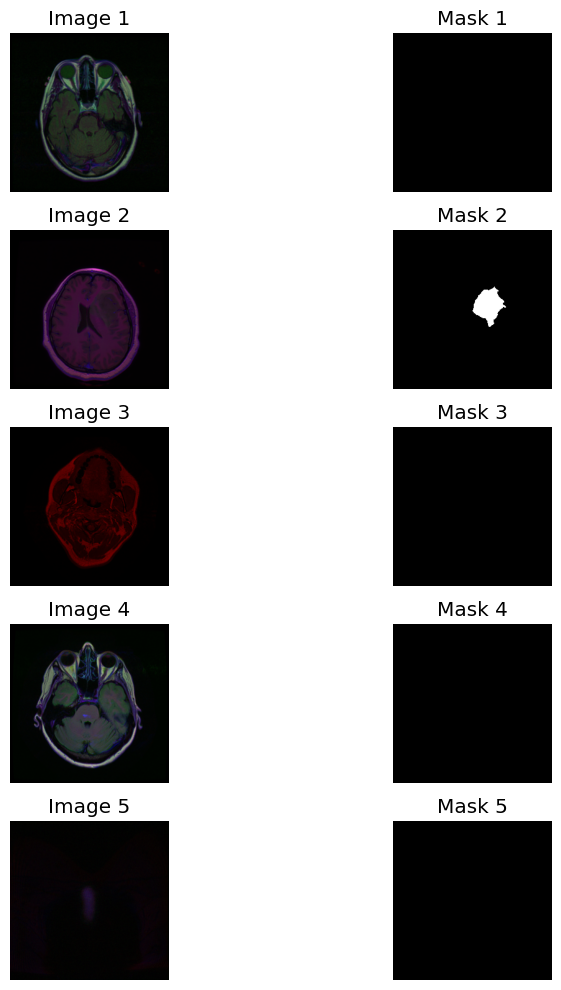

In [ ]:
import matplotlib.pyplot as plt
import cv2

num_images_to_show = 5  
fig, axes = plt.subplots(num_images_to_show, 2, figsize=(10, 10))

for i in range(num_images_to_show):
    image_path = train.iloc[i]['images'] 
    mask_path = train.iloc[i]['masks']   
    image = cv2.imread(image_path)  
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  

    image = cv2.resize(image, (256, 256))
    mask = cv2.resize(mask, (256, 256))

    # Convertir l'image pour l'affichage avec matplotlib (BGR -> RGB)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    axes[i, 0].imshow(image_rgb)
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f"Image {i + 1}")
    
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f"Mask {i + 1}")

plt.tight_layout()
plt.show()


In [ ]:
val['images'] = val.apply(lambda row: os.path.join(DataPath, row['patient_id'], row['images']), axis=1)
val['masks'] = val.apply(lambda row: os.path.join(DataPath, row['patient_id'], row['masks']), axis=1)

val_generator = data_generator(
    data_frame=val, 
    batch_size=32,      
    aug_dict={},         
    target_size=(256, 256)  
)


In [ ]:
small_train_df = train.sample(n=10)  
small_train_generator = data_generator(
    data_frame=small_train_df,  
    batch_size=2,      
    aug_dict=data_augmentation, 
    target_size=(256, 256)
)

sample_small_batch = next(small_train_generator)

print("Small batch image shape:", sample_small_batch[0].shape)
print("Small batch mask shape:", sample_small_batch[1].shape)


Found 10 validated image filenames.
Found 10 validated image filenames.
Small batch image shape: (2, 256, 256, 3)
Small batch mask shape: (2, 256, 256, 1)


In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, UpSampling2D, Reshape, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

def SqueezeAndExcite(inputs, ratio=8):
    init = inputs
    filters = init.shape[-1]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    x = init * se
    return x

def ASPP(inputs):
    shape = inputs.shape
    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(inputs)
    y1 = Conv2D(256, 1, padding="same", use_bias=False)(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y1)

    y2 = Conv2D(256, 1, padding="same", use_bias=False)(inputs)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(256, 3, padding="same", use_bias=False, dilation_rate=6)(inputs)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(256, 3, padding="same", use_bias=False, dilation_rate=12)(inputs)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(256, 3, padding="same", use_bias=False, dilation_rate=18)(inputs)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])
    y = Conv2D(256, 1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

def deeplabv3_plus(shape):
    inputs = Input(shape)
    encoder = ResNet50(weights="imagenet", include_top=False, input_tensor=inputs)
    
    image_features = encoder.get_layer("conv4_block6_out").output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    x_b = encoder.get_layer("conv2_block2_out").output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)

    x = Concatenate()([x_a, x_b])
    x = SqueezeAndExcite(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SqueezeAndExcite(x)

    x = UpSampling2D((4, 4), interpolation="bilinear")(x)
    x = Conv2D(1, 1)(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs, x)
    return model

if __name__ == "__main__":
    model = deeplabv3_plus((256, 256, 3))


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 17,869,697 (68.17 MB)

 Trainable params: 17,834,913 (68.03 MB)

 Non-trainable params: 34,784 (135.88 KB)

In [ ]:
smooth = 1e-15

def iou_score(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (union - intersection + smooth)
    return iou

def dice_coefficient(y_true, y_pred):
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)
    intersection = K.sum(y_true_flat * y_pred_flat)
    dice = (2 * intersection + smooth) / (K.sum(y_true_flat) + K.sum(y_pred_flat) + smooth)
    return dice

def dice_coefficient_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)


In [18]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

lr_reduction = ReduceLROnPlateau(factor=0.1, min_lr=1e-5, verbose=1),
early_stop = EarlyStopping(monitor='val_dice_coefficient', min_delta=0.00001, patience=6, mode='max', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('unet_model.keras', monitor='val_dice_coefficient', verbose=1, save_best_only=True, mode='max')


In [ ]:
from tensorflow.keras.metrics import Recall, Precision

learning_rate = 1e-5
EPOCH = 100

model.compile(
    optimizer=Adam(learning_rate=learning_rate, ), 
    loss=dice_coefficient_loss,
    metrics=[dice_coefficient, iou_score, Recall(), Precision()]
)
steps_per_epoch = int(len(train) / 32)
validation_steps = int(len(val) / 32)
print(steps_per_epoch)
print(validation_steps)
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCH,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[lr_reduction, model_checkpoint]
)



82
9
Found 2651 validated image filenames.
Found 2651 validated image filenames.
Epoch 1/100


I0000 00:00:1731957702.213702     123 service.cc:145] XLA service 0x7e5704003e10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731957702.213770     123 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-11-18 19:22:14.527602: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng19{k5=1,k6=0,k7=1,k10=2} for conv (f32[10368,1024,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[10368,256,1,1]{3,2,1,0}, f32[256,1024,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-11-18 19:22:14.633887: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.106442772s
Trying algorithm eng

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - dice_coefficient: 0.0339 - iou_score: 0.0173 - loss: 0.9661 - precision: 0.0284 - recall: 0.7846Found 295 validated image filenames.
Found 295 validated image filenames.

Epoch 1: val_dice_coefficient improved from -inf to 0.02020, saving model to unet_model.keras
82/82 ━━━━━━━━━━━━━━━━━━━━ 157s 748ms/step - dice_coefficient: 0.0340 - iou_score: 0.0174 - loss: 0.9660 - precision: 0.0285 - recall: 0.7865 - val_dice_coefficient: 0.0202 - val_iou_score: 0.0102 - val_loss: 0.9798 - val_precision: 0.0460 - val_recall: 0.5631 - learning_rate: 1.0000e-05
Epoch 2/100


2024-11-18 19:24:01.355885: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[256,8748,1,1]{3,2,1,0}, u8[0]{0}) custom-call(f32[1024,8748,3,3]{3,2,1,0}, f32[1024,256,3,3]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-11-18 19:24:01.620641: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.264900406s
Trying algorithm eng0{} for conv (f32[256,8748,1,1]{3,2,1,0}, u8[0]{0}) custom-call(f32[1024,8748,3,3]{3,2,1,0}, f32[1024,256,3,3]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - dice_coefficient: 0.0733 - iou_score: 0.0382 - loss: 0.9266 - precision: 0.0682 - recall: 0.9882
Epoch 2: val_dice_coefficient improved from 0.02020 to 0.02236, saving model to unet_model.keras
82/82 ━━━━━━━━━━━━━━━━━━━━ 117s 769ms/step - dice_coefficient: 0.0735 - iou_score: 0.0383 - loss: 0.9264 - precision: 0.0684 - recall: 0.9881 - val_dice_coefficient: 0.0224 - val_iou_score: 0.0113 - val_loss: 0.9791 - val_precision: 0.1215 - val_recall: 0.0182 - learning_rate: 1.0000e-05
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - dice_coefficient: 0.1477 - iou_score: 0.0805 - loss: 0.8523 - precision: 0.1970 - recall: 0.9442
Epoch 3: val_dice_coefficient did not improve from 0.02236
82/82 ━━━━━━━━━━━━━━━━━━━━ 54s 658ms/step - dice_coefficient: 0.1481 - iou_score: 0.0807 - loss: 0.8519 - precision: 0.1977 - recall: 0.9442 - val_dice_coefficient: 0.0171 - val_iou_score: 0.0086 - val_loss: 0.9823 - val_precision: 0.0000e+00 - val_recall: 0.0000

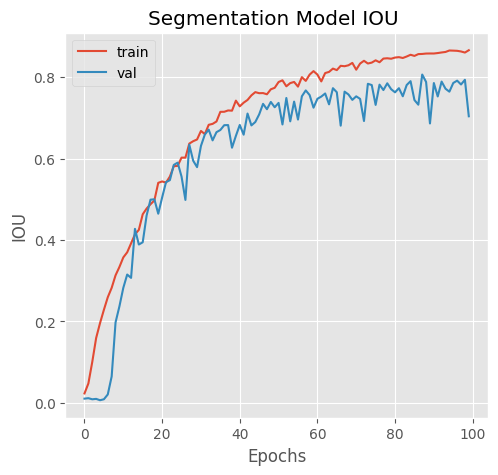

In [27]:

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['iou_score']);
plt.plot(history.history['val_iou_score']);
plt.title("Segmentation Model IOU ");
plt.ylabel("IOU");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

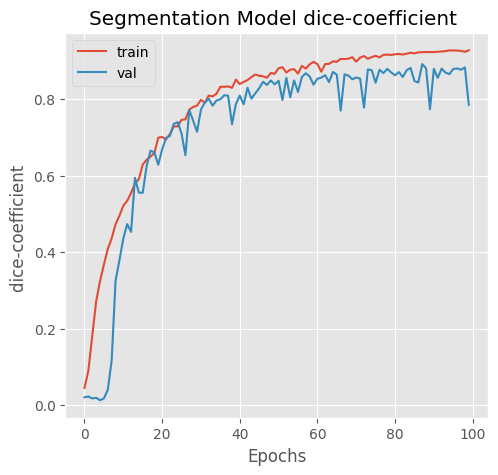

In [21]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['dice_coefficient']);
plt.plot(history.history['val_dice_coefficient']);
plt.title("Segmentation Model dice-coefficient ");
plt.ylabel("dice-coefficient ");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

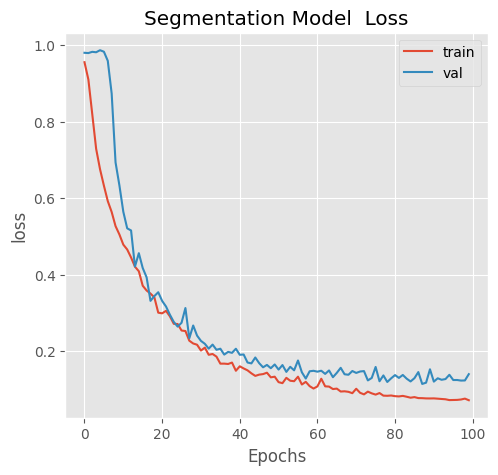

In [22]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);
plt.title("Segmentation Model  Loss");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [ ]:
DataPath = "/kaggle/working/lgg_mri_segmentation/kaggle_3m/"

test['images'] = test.apply(lambda row: DataPath + row['patient_id'] + "/" + row['images'], axis=1)
test['masks'] = test.apply(lambda row: DataPath + row['patient_id'] + "/" + row['masks'], axis=1)

print(test.head())


                 patient_id  \
1006  TCGA_DU_5852_19950709   
1217  TCGA_CS_4942_19970222   
3267  TCGA_CS_6290_20000917   
2033  TCGA_DU_A5TS_19970726   
3419  TCGA_DU_7013_19860523   

                                                 images  \
1006  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
1217  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
3267  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
2033  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
3419  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   

                                                  masks  diagnosis  
1006  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          0  
1217  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          1  
3267  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          0  
2033  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          0  
3419  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          0  


In [ ]:
def combined_generator(image_generator, mask_generator):
    while True:
        image_batch, mask_batch = next(image_generator), next(mask_generator)
        yield image_batch, mask_batch

image_datagen = ImageDataGenerator(rescale=1./255)
mask_datagen = ImageDataGenerator(rescale=1./255)

test_image_generator = image_datagen.flow_from_dataframe(
    dataframe=test,  
    x_col="images",   
    class_mode=None,  
    color_mode="rgb",
    target_size=(256, 256),  
    batch_size=32,
    seed=42,
    validate_filenames=False  
)

test_mask_generator = mask_datagen.flow_from_dataframe(
    dataframe=test,  
    x_col="masks",   
    class_mode=None,  
    color_mode="grayscale",  
    target_size=(256, 256),  
    batch_size=32,
    seed=42,
    validate_filenames=False 
)

test_generator = combined_generator(test_image_generator, test_mask_generator)

steps_per_epoch_test = len(test) // 32  

test_loss, test_dice_coef, test_iou, test_recall, test_precision = model.evaluate(
    test_generator, steps=steps_per_epoch_test, verbose=1
)

print(f"Test Loss: {test_loss}")
print(f"Test Dice Coefficient: {test_dice_coef}")
print(f"Test IoU: {test_iou}")
print(f"Test Recall: {test_recall}")
print(f"Test Precision: {test_precision}")


Found 983 non-validated image filenames.
Found 983 non-validated image filenames.
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 301ms/step - dice_coefficient: 0.8905 - iou_score: 0.8033 - loss: 0.1095 - precision: 0.9081 - recall: 0.8927
Test Loss: 0.10792134702205658
Test Dice Coefficient: 0.8920785784721375
Test IoU: 0.8060846328735352
Test Recall: 0.8916293978691101
Test Precision: 0.9124288558959961


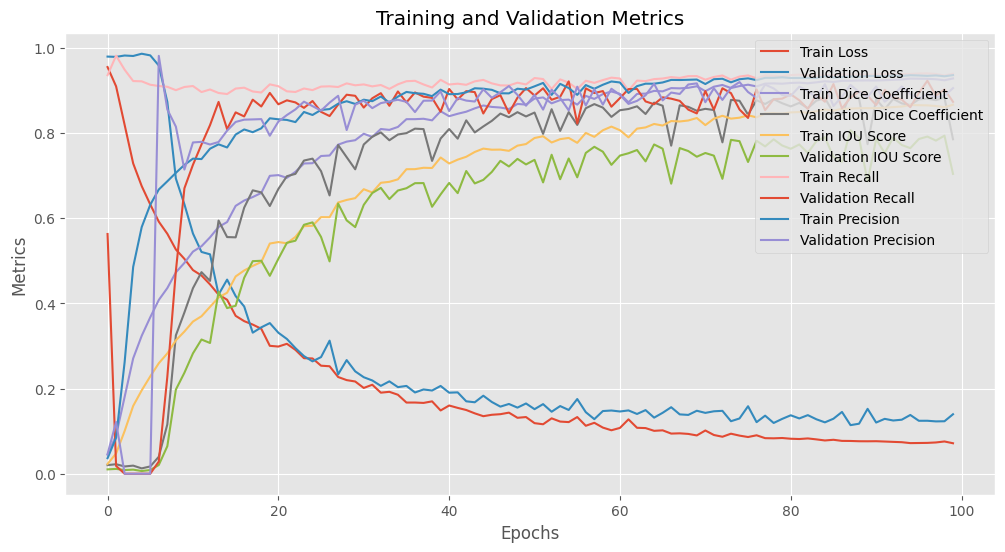

In [ ]:
plt.figure(figsize=(12, 6))

# Tracer la perte (loss)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Tracer Dice Coefficient
if 'dice_coefficient' in history.history:
    plt.plot(history.history['dice_coefficient'], label='Train Dice Coefficient')
if 'val_dice_coefficient' in history.history:
    plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')

# Tracer IOU Score
if 'iou_score' in history.history:
    plt.plot(history.history['iou_score'], label='Train IOU Score')
if 'val_iou_score' in history.history:
    plt.plot(history.history['val_iou_score'], label='Validation IOU Score')

# Tracer Recall
if 'recall' in history.history:
    plt.plot(history.history['recall'], label='Train Recall')
if 'val_recall' in history.history:
    plt.plot(history.history['val_recall'], label='Validation Recall')

# Tracer Precision
if 'precision' in history.history:
    plt.plot(history.history['precision'], label='Train Precision')
if 'val_precision' in history.history:
    plt.plot(history.history['val_precision'], label='Validation Precision')

plt.title("Training and Validation Metrics")
plt.ylabel("Metrics")
plt.xlabel("Epochs")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


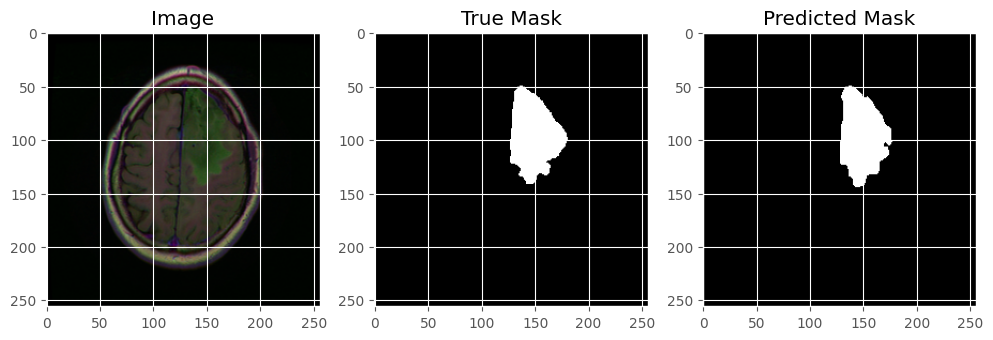

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


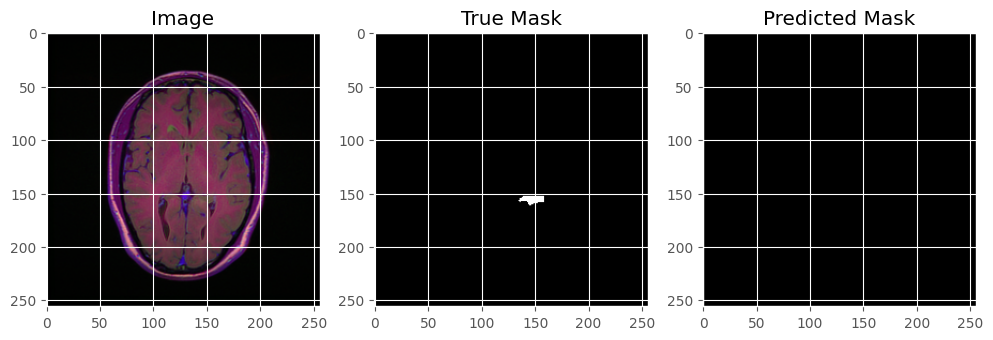

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


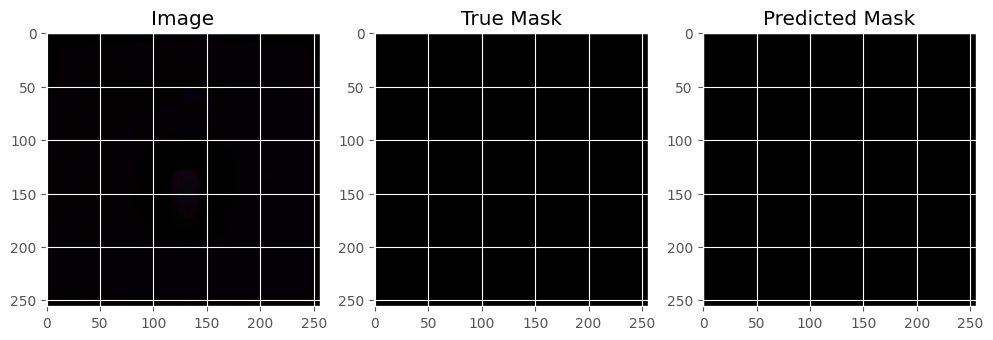

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


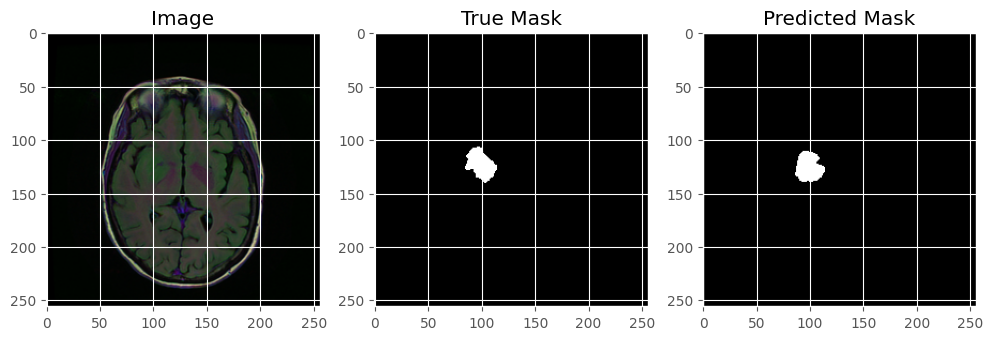

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


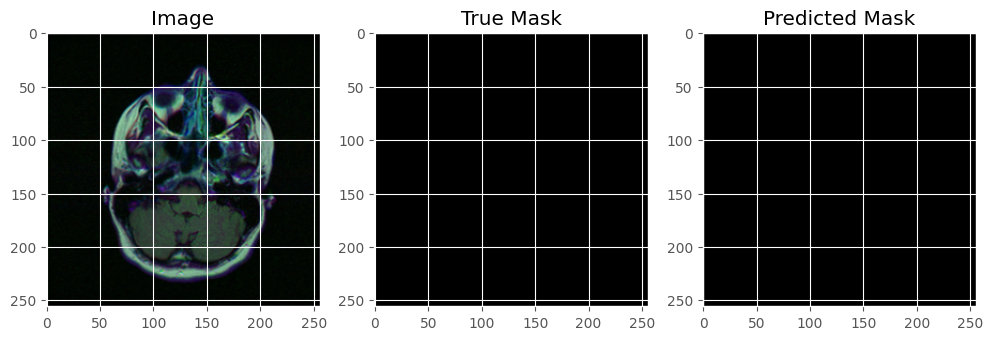

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


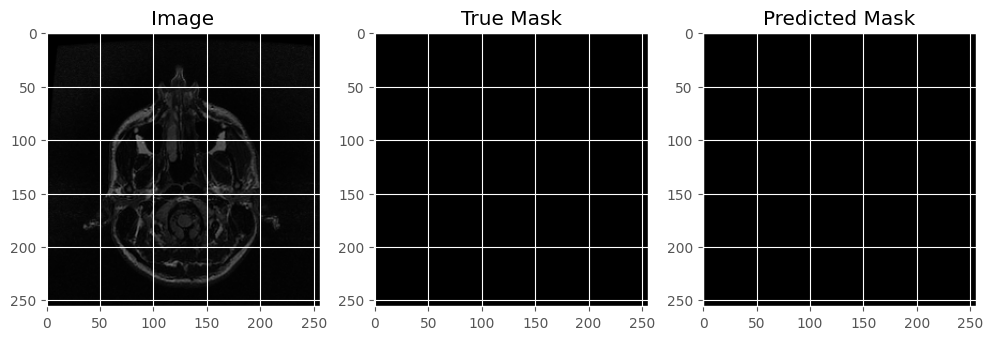

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


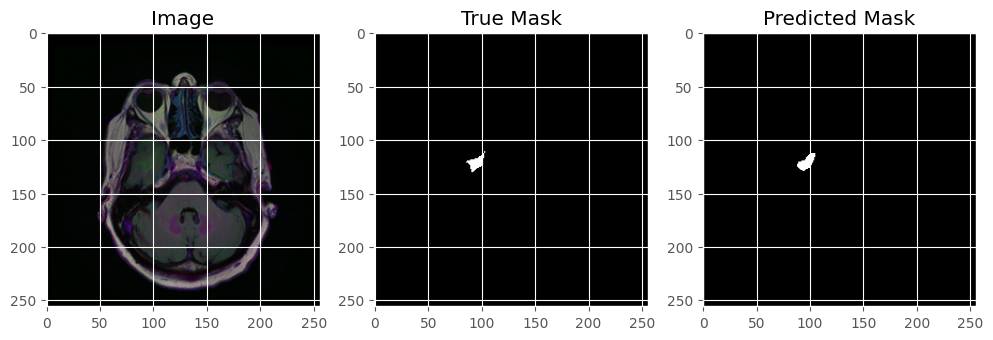

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


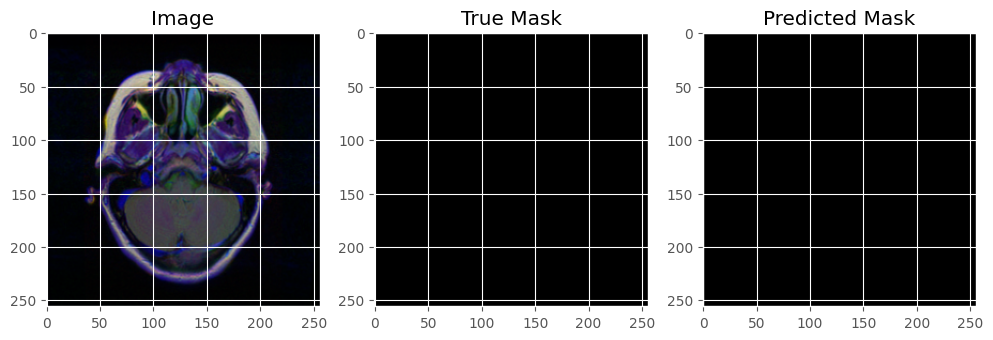

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


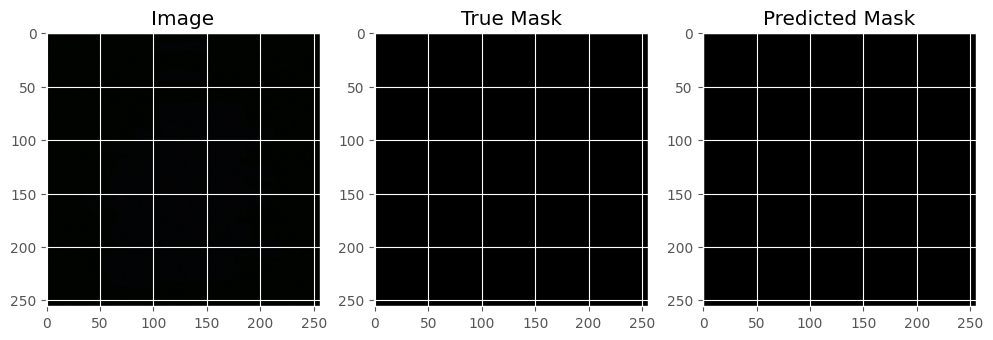

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


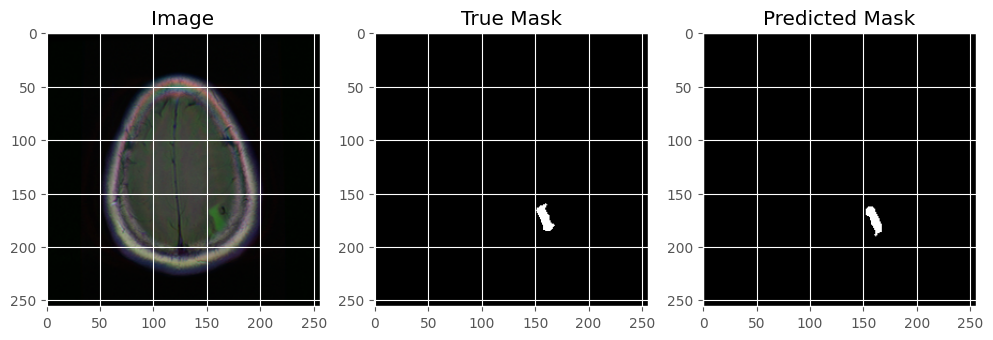

In [ ]:


for i in range(10):
    image, mask = next(test_generator)
    predicted_mask = model.predict(image)
    binary_predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

    plt.figure(figsize=(12, 4))

    # Image d'entrée
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(image[0])

    # Masque réel
    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(mask[0].squeeze(), cmap="gray")

    # Masque prédit binarisé
    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(binary_predicted_mask[0].squeeze(), cmap="gray")

    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


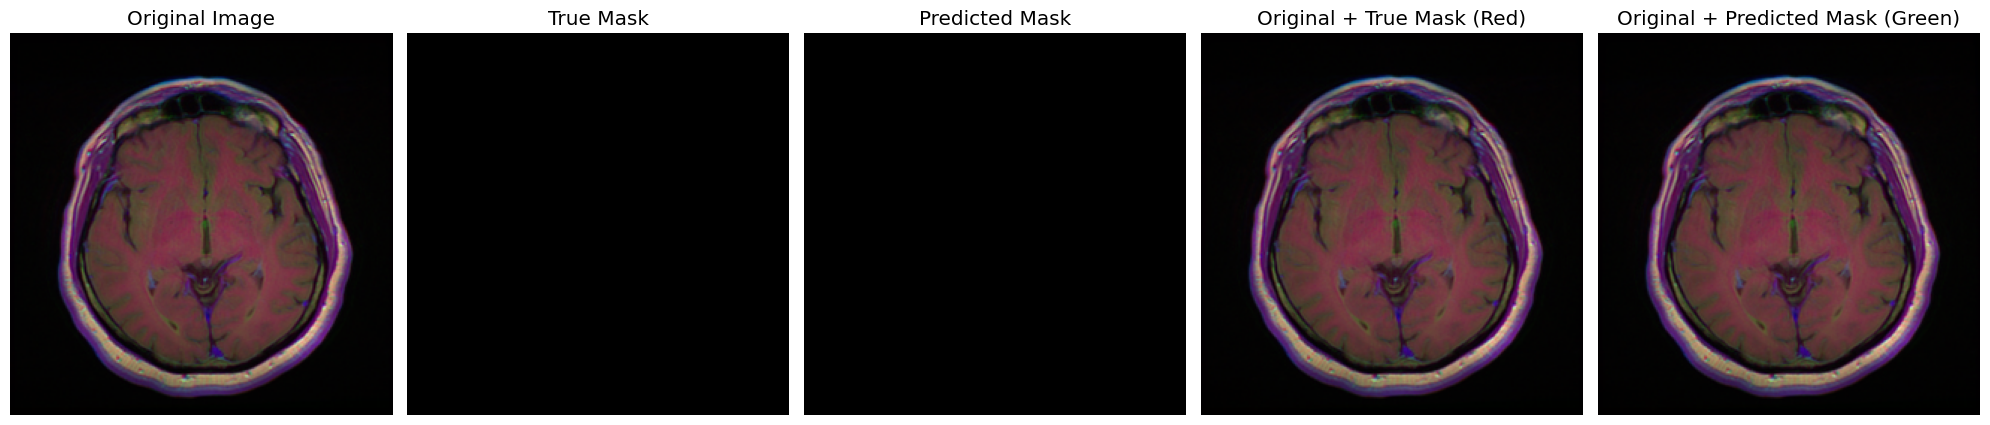

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


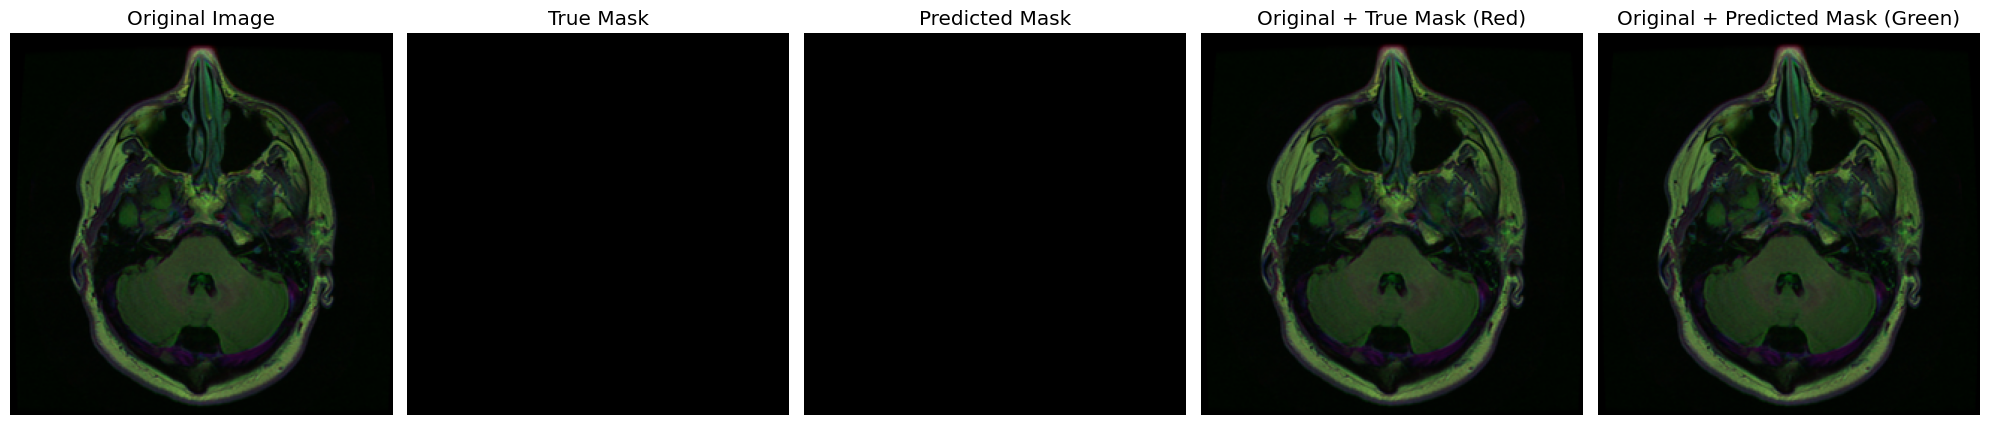

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


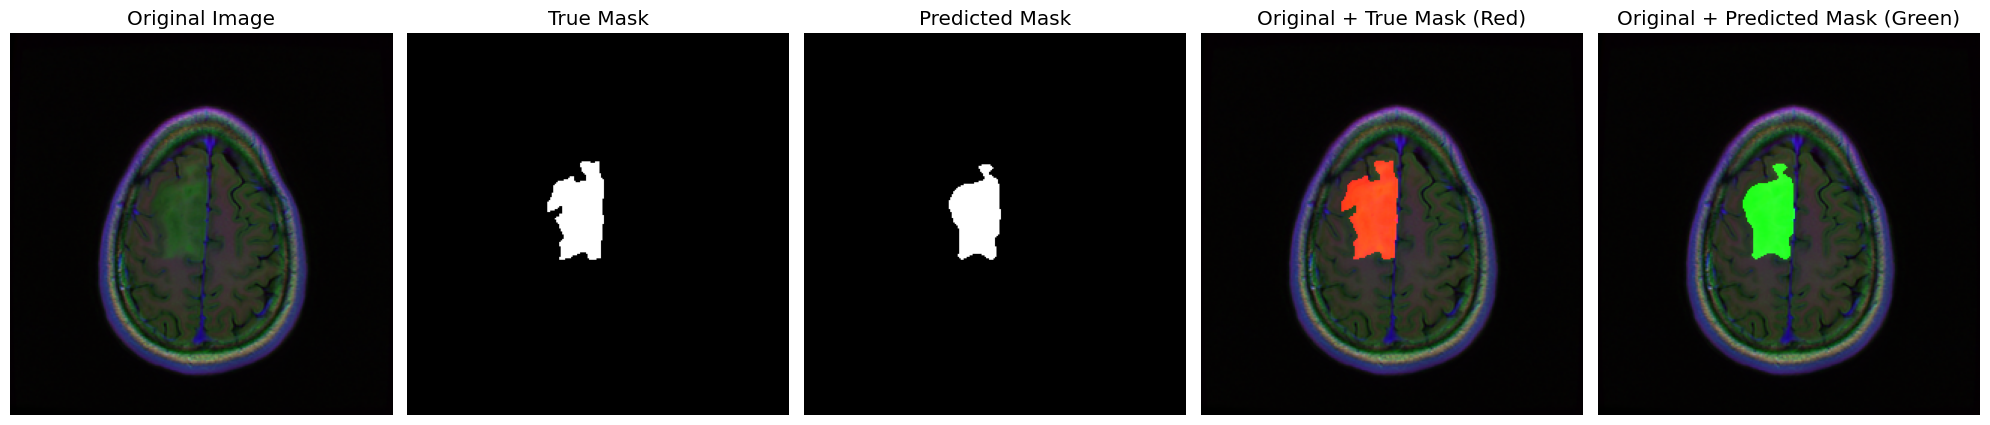

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


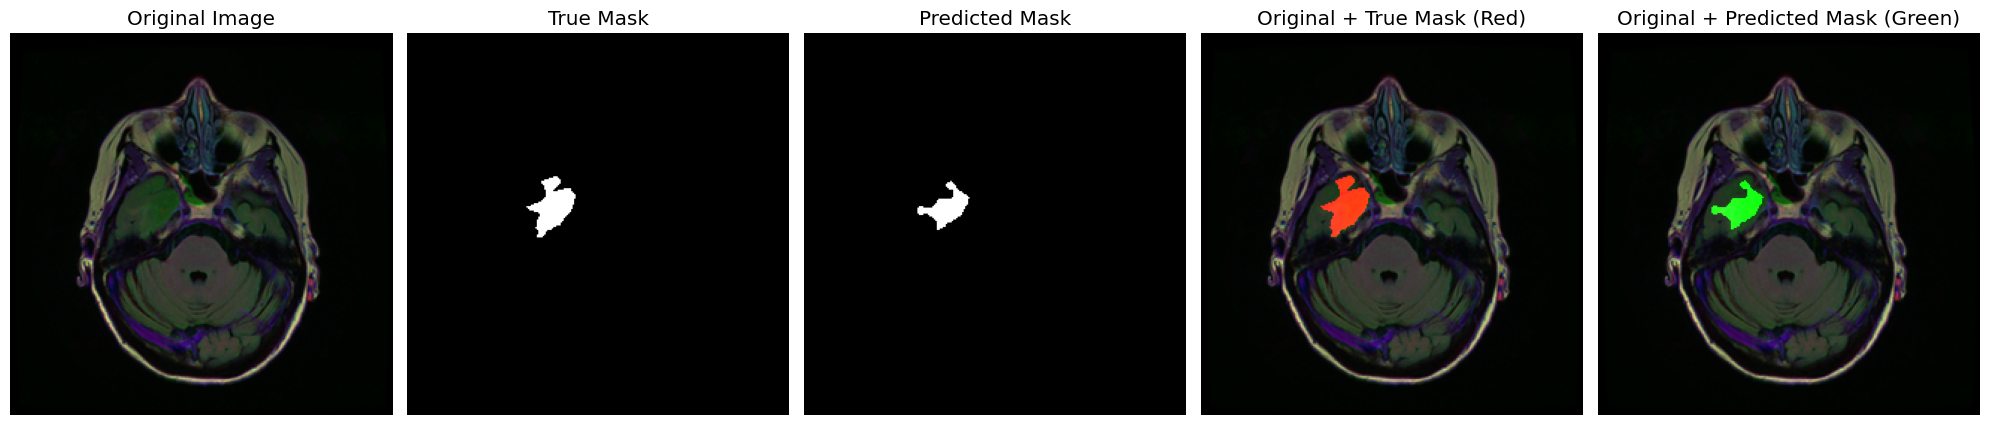

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


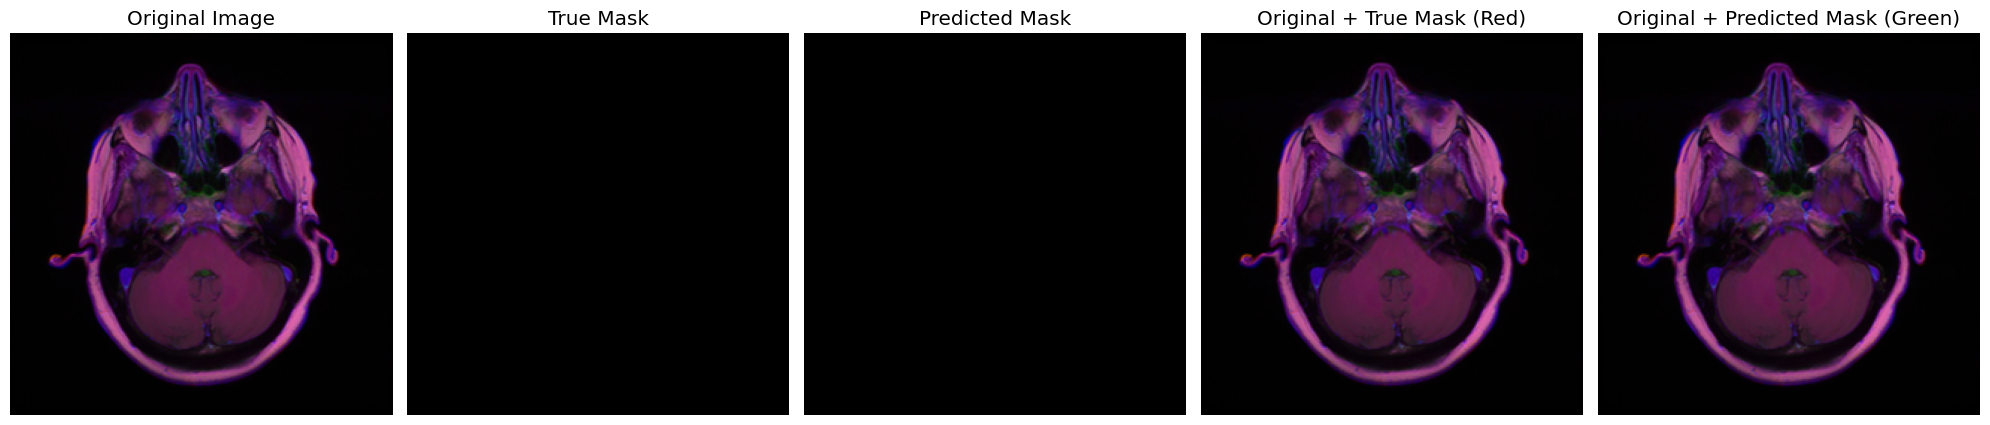

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


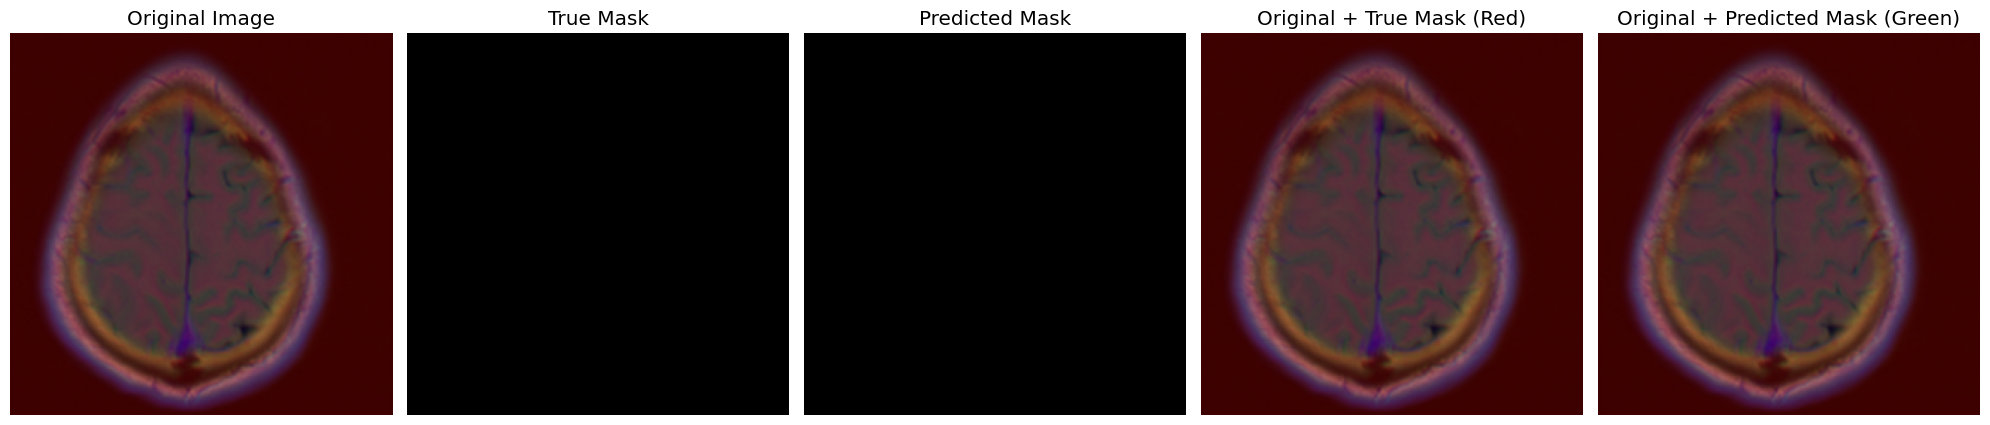

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


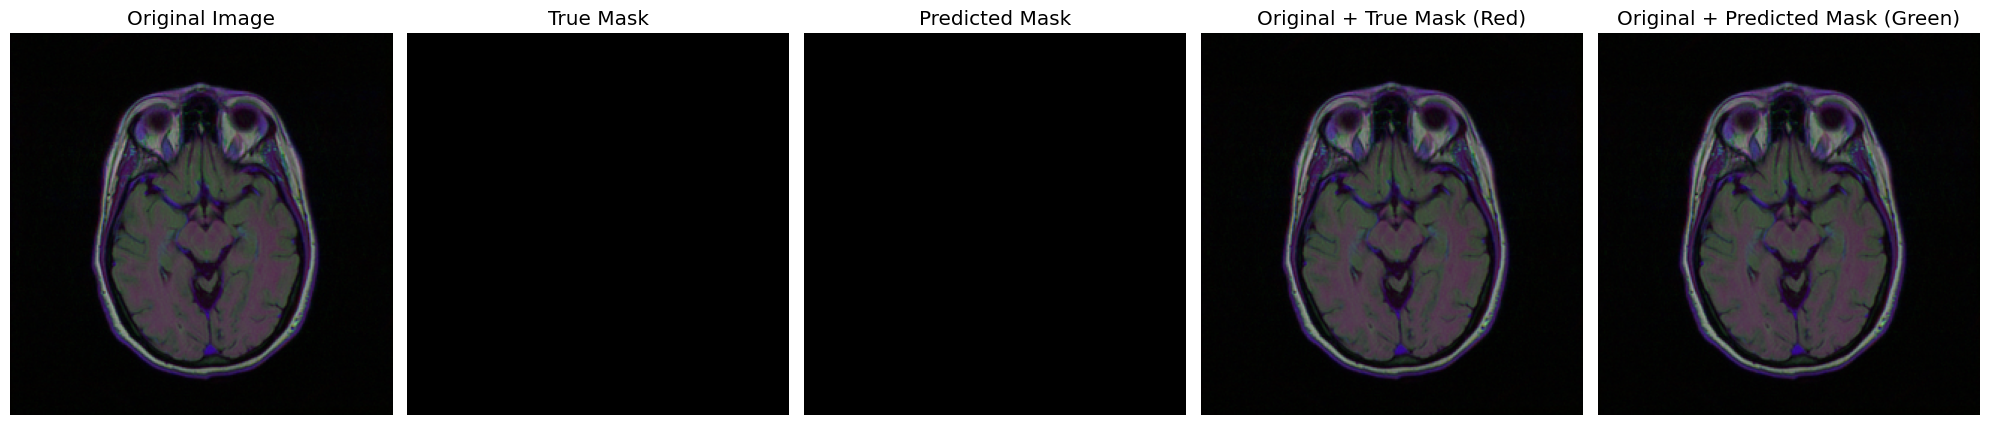

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


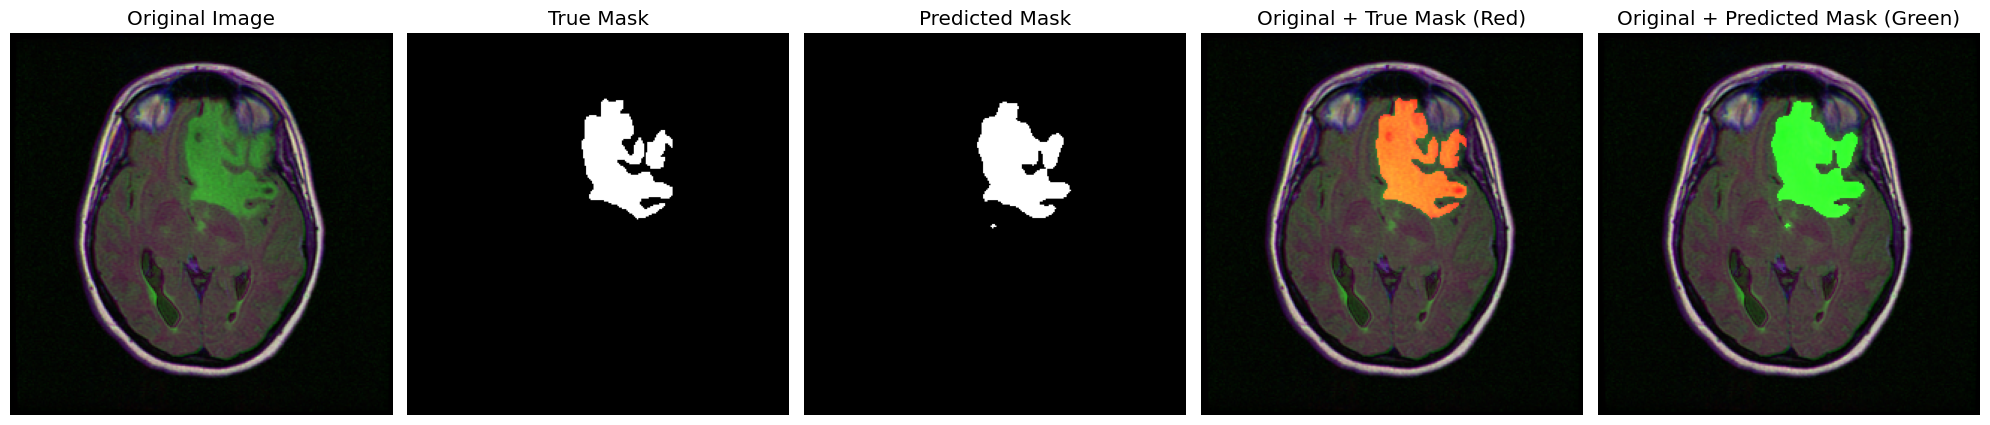

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


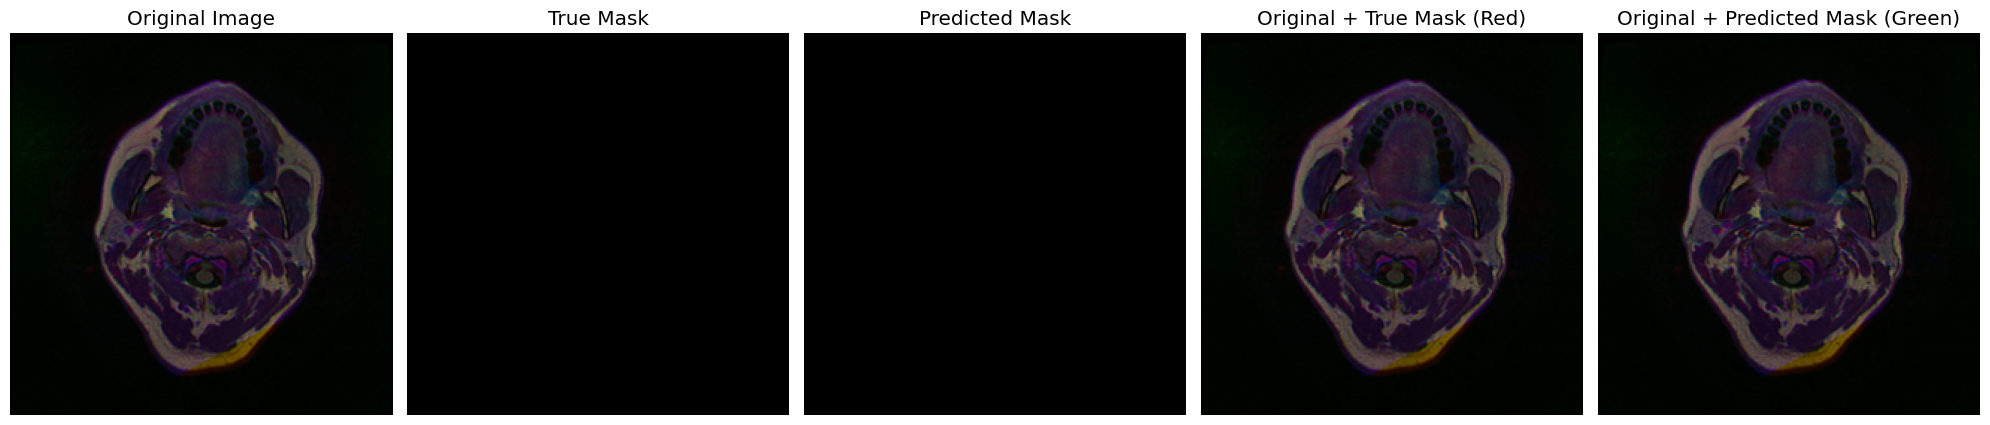

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


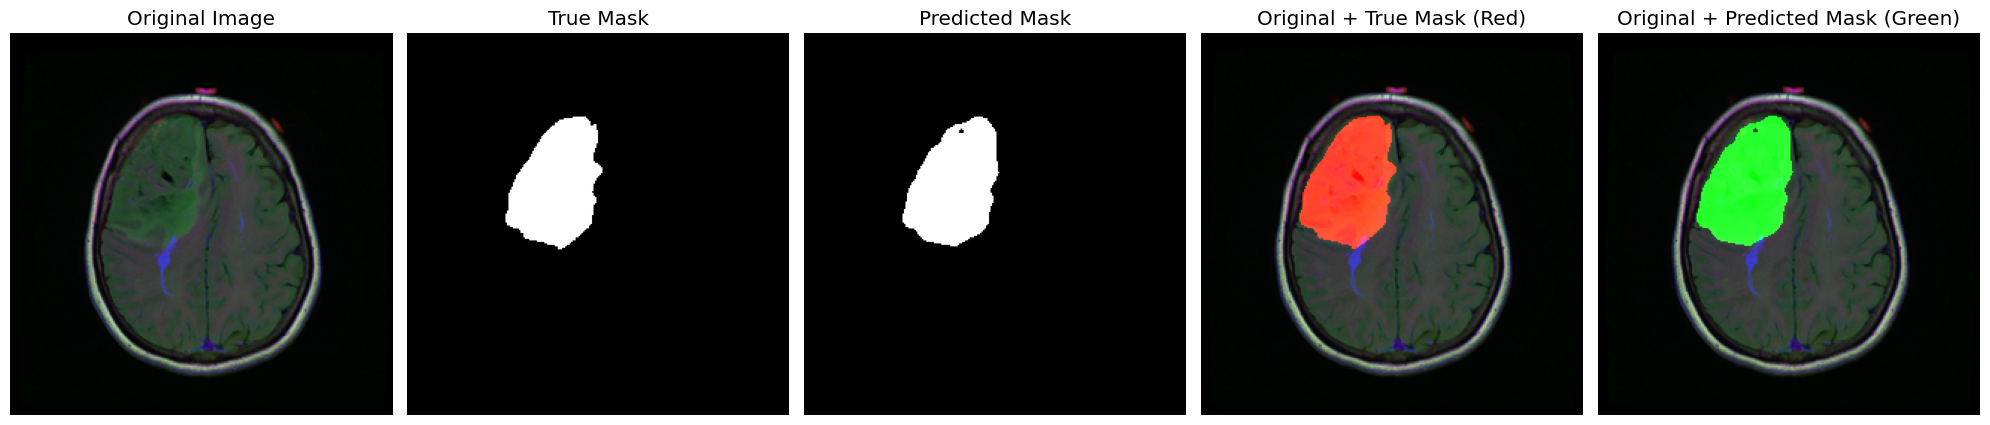

In [ ]:
for i in range(10):
    image, mask = next(test_generator)
    # Prédiction du masque
    predicted_mask = model.predict(image)
    binary_predicted_mask = (predicted_mask > 0.5).astype(np.uint8)
    # Création des images avec superpositions
    image_with_true_mask = image[0].copy()  
    image_with_predicted_mask = image[0].copy() 

    # Ajouter le masque réel en rouge
    image_with_true_mask[..., 0] = np.maximum(image_with_true_mask[..., 0], mask[0].squeeze() * 255) 

    # Ajouter le masque prédit en vert
    image_with_predicted_mask[..., 1] = np.maximum(image_with_predicted_mask[..., 1], binary_predicted_mask[0].squeeze() * 255)  

    plt.figure(figsize=(20, 8))

    # Image originale
    plt.subplot(1, 5, 1)
    plt.title("Original Image")
    plt.imshow(image[0])
    plt.axis("off")

    # Masque réel
    plt.subplot(1, 5, 2)
    plt.title("True Mask")
    plt.imshow(mask[0].squeeze(), cmap="gray")
    plt.axis("off")

    # Masque prédit
    plt.subplot(1, 5, 3)
    plt.title("Predicted Mask")
    plt.imshow(binary_predicted_mask[0].squeeze(), cmap="gray")
    plt.axis("off")

    # Image + True Mask
    plt.subplot(1, 5, 4)
    plt.title("Original + True Mask (Red)")
    plt.imshow(image_with_true_mask)
    plt.axis("off")

    # Image + Predicted Mask
    plt.subplot(1, 5, 5)
    plt.title("Original + Predicted Mask (Green)")
    plt.imshow(image_with_predicted_mask)
    plt.axis("off")

    plt.tight_layout()
    plt.show()
